In [1]:
from DLtools.Data_preprocess import load_data, series_to_supervised

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

# Define Function

In [2]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # store
        scores.append(mse)
        
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2    
    score = (s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    val_x, val_y = to_supervised(test, n_input)
    VALIDATION = (val_x,val_y)

    model = build_model(train, n_input,VALIDATION)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [3]:
# train the model
def build_model(train, n_input,validation):
    # define parameters
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    # fit network
    history =  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=validation)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model

In [4]:
def train_test(data,n_out):    
    ratio = int(len(data)*.7)
    d_start = int(ratio-ratio%n_out)
    d_end = int(len(data)-len(data)%n_out)
    #train,test = X_in.iloc[:700,:].values,X_in.iloc[700:777,:].values
    train,test = data[:d_start,:],data[d_start:d_end,:]

    train = np.array(np.split(train, len(train)/n_out))
    test = np.array(np.split(test, len(test)/n_out))
    return train,test

def to_supervised(train, n_input, n_out=7):
    # flatten data
    try :
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    except:
        data = train.values
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out   
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])   #Y is the first columns
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

def train_test(data,n_out):    
    ratio = int(len(data)*.7)
    d_start = int(ratio-ratio%n_out)
    d_end = int(len(data)-len(data)%n_out)
    #train,test = X_in.iloc[:700,:].values,X_in.iloc[700:777,:].values
    train,test = data[:d_start,:],data[d_start:d_end,:]

    train = np.array(np.split(train, len(train)/n_out))
    test = np.array(np.split(test, len(test)/n_out))
    return train,test

# Load Data

In [5]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean()

DataFrame shape: (465169, 35)


In [6]:
X_in = df["2015-01-01":"2018-01-05"].interpolate(limit=30)
X_in = X_in.astype('float32')
X_in = df.fillna(0)

In [7]:
TARGET = 'CPY015_w'
X_in = move_column_inplace(X_in,TARGET,0)
X_in.head()

,CPY015_w,CHM002_r,CHM004_r,CHM006_r,CPY004_r,CPY009_r,CPY010_r,CPY015_r,KWN002_r,NAN006_r,...,CPY010_w,KWN002_w,NAN009_w,NAN010_w,NAN011_w,NAN012_w,NAN013_w,PIN001_w,PIN004_w,THA001_w
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.797222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.905664,0.0,0.0,0.0,0.0,0.0,0.0,119.359161,40.765833,15.046528
2013-01-02,0.636250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.793056,0.0,0.0,0.0,0.0,0.0,0.0,119.383333,40.826023,15.028889
2013-01-03,0.581458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.771111,0.0,0.0,0.0,0.0,0.0,0.0,119.499650,40.822639,14.972569
2013-01-04,0.532153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.681250,0.0,0.0,0.0,0.0,0.0,0.0,119.406434,40.872361,14.956528
2013-01-05,0.530139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.671736,0.0,0.0,0.0,0.0,0.0,0.0,119.403287,40.996559,14.932222


In [8]:
scale = MinMaxScaler()
X_in = scale.fit_transform(X_in)

In [9]:
n_input = 30
n_out = 14

train, test = train_test(X_in,n_out=n_out)

train_x, train_y =  to_supervised(train, n_input)
val_x, val_y = to_supervised(test, n_input)
VALIDATION = (val_x,val_y)

In [10]:
model = build_model(train,n_input,VALIDATION)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               188800    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 209,607
Trainable params: 209,607
Non-trainable params: 0
_________________________________________________________________


In [1]:
trainPredict = model.predict(train_x)
testPredict = model.predict(val_x)

NameError: name 'model' is not defined

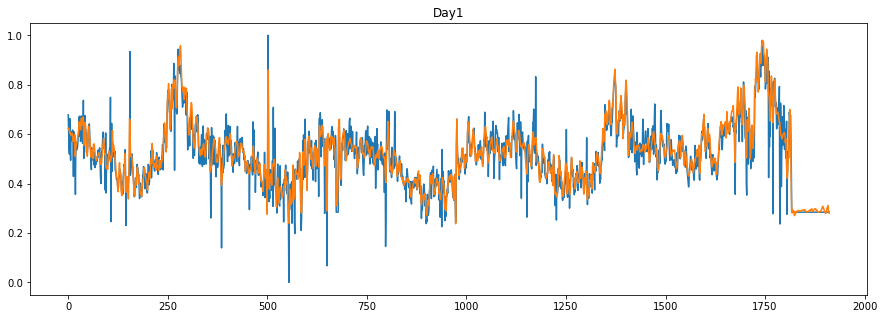

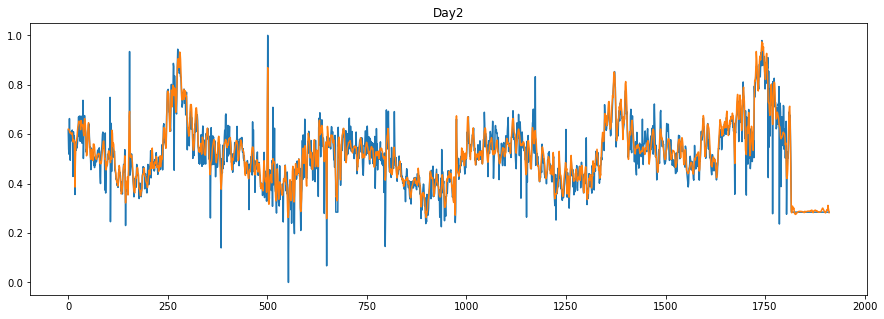

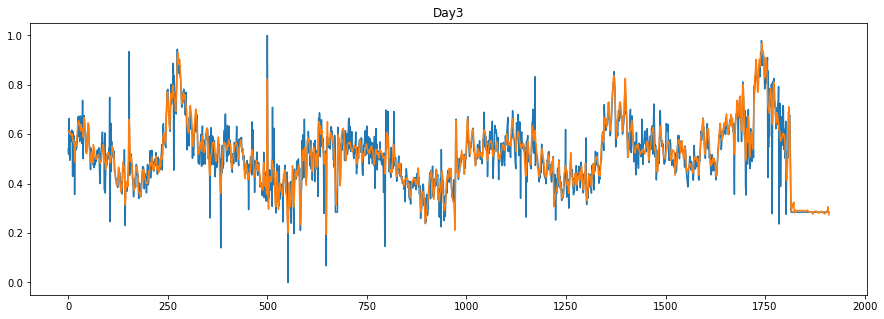

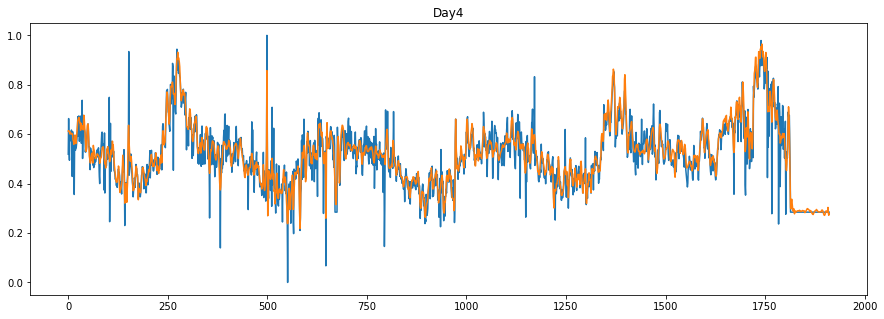

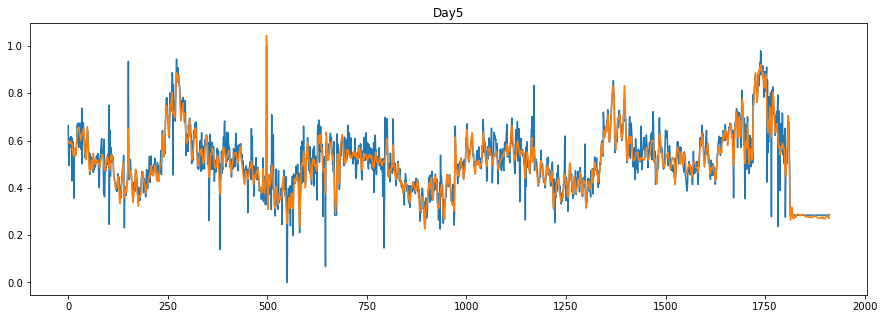

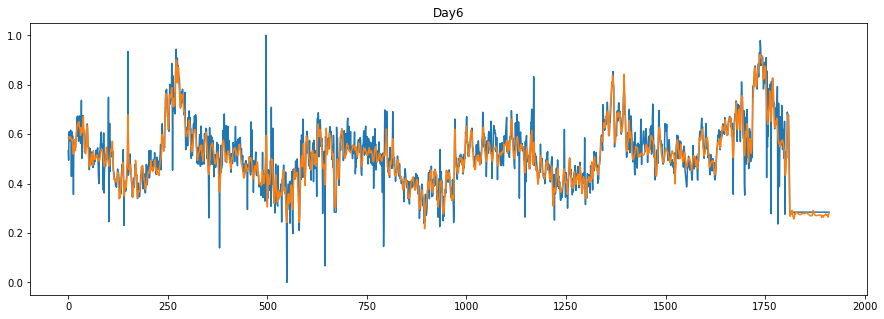

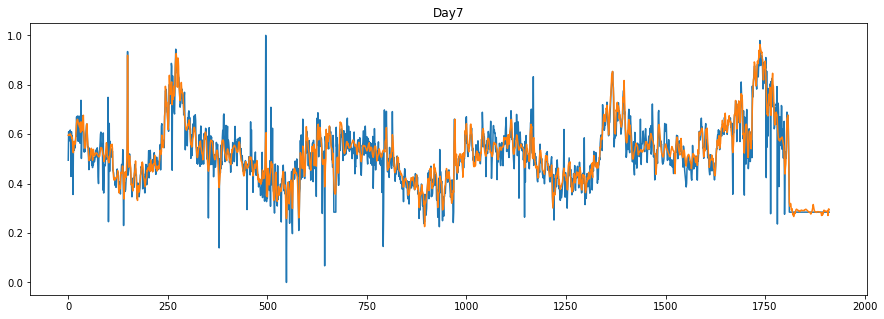

In [44]:
for i in range(train_y.shape[1]):
    plt.figure(figsize=(15,5))
    plt.plot(train_y[:,i])
    plt.plot(trainPredict[:,i])
    plt.title('Day{}'.format(i+1))
    plt.show()

In [52]:
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = np.array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

In [47]:
predictions.shape

(119, 7)

In [49]:
test[:,:,0].shape

(119, 7)